**Each datafile was moved left or right about 61 cm (24 inches)**

In [1]:
%matplotlib notebook

import scipy
import pandas as pd
import numpy as np
import glob
import json
from pprint import pprint
from collections import OrderedDict
from math import sin, cos, radians

from IPython.core.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [10]:
path = "./data/"
files = glob.glob(f"{path}*.json")
files = sorted(files)
files

['./data/data_2019-05-16-001527.json',
 './data/data_2019-05-16-001536.json',
 './data/data_2019-05-16-001544.json',
 './data/data_2019-05-16-001552.json',
 './data/data_2019-05-16-001604.json']

In [87]:
raw = []
datafile = files[0]
with open(datafile, "r") as f:
    for row in f:
        item = json.loads(row)
        raw.append(item)

print("{} samples".format(len(raw)))
pprint(raw[0])

219 samples
{'distance': {'cm': 1567.98, 'inches': 617.32},
 'euler_angles': {'heading': 262.6875, 'pitch': 0.6875, 'roll': -1.625},
 'imu_calibration': {'accelerometer': 3,
                     'gyroscope': 3,
                     'magnetometer': 3,
                     'system': 0},
 'linear_acceleration': {'x': 0.06, 'y': 0.02, 'z': -0.27},
 'quaternion': {'w': 0.66064453125,
                'x': -0.0152587890625,
                'y': 0.0047607421875,
                'z': 0.75054931640625},
 'time': {'scale': 'microsecond', 'start': 1557980127259250}}


In [181]:
def transform(instance):
    obj = {
        "microseconds": instance["time"]["start"],
    }
    obj.update(instance["linear_acceleration"])
    return obj

df = pd.DataFrame([transform(ii) for ii in raw]).sort_values(by=['microseconds'])
df["time"] = pd.to_datetime(df["microseconds"], unit='us')

let's preview some of the data

In [182]:
df.head()

,microseconds,x,y,z,time
0,1557980127259250,0.06,0.02,-0.27,2019-05-16 04:15:27.259250
1,1557980127366190,0.05,0.02,-0.29,2019-05-16 04:15:27.366190
2,1557980127475129,0.06,0.01,-0.28,2019-05-16 04:15:27.475129
3,1557980127583855,0.07,0.00,-0.30,2019-05-16 04:15:27.583855
4,1557980127697613,0.06,0.03,-0.27,2019-05-16 04:15:27.697613


light statistical analysis of accelleration vectors

In [183]:
df.describe()

,microseconds,x,y,z
count,2.190000e+02,219.000000,219.000000,219.000000
mean,1.557980e+15,0.048539,-0.009041,-0.278676
std,2.285787e+06,0.186005,0.114557,0.020667
min,1.557980e+15,-0.630000,-0.360000,-0.340000
25%,1.557980e+15,0.005000,-0.050000,-0.290000
50%,1.557980e+15,0.070000,-0.010000,-0.280000
75%,1.557980e+15,0.105000,0.030000,-0.270000
max,1.557980e+15,0.830000,0.410000,-0.150000


In [184]:
# df["z"] = df["z"] - df["z"].mean()
# df["x"] = df["x"] - df["x"].mean()
df.describe()

,microseconds,x,y,z
count,2.190000e+02,219.000000,219.000000,219.000000
mean,1.557980e+15,0.048539,-0.009041,-0.278676
std,2.285787e+06,0.186005,0.114557,0.020667
min,1.557980e+15,-0.630000,-0.360000,-0.340000
25%,1.557980e+15,0.005000,-0.050000,-0.290000
50%,1.557980e+15,0.070000,-0.010000,-0.280000
75%,1.557980e+15,0.105000,0.030000,-0.270000
max,1.557980e+15,0.830000,0.410000,-0.150000


In [185]:
duration = (df["time"].iloc[-1] - df["time"].iloc[0]) 
print(f"{duration.seconds}.{duration.microseconds} seconds")
print("{} samples".format(df.shape[0]))
# print("{} samples/sec".format(df.shape[0] / df["time"].iloc[-1] - df["time"].iloc[0]))

9.343926 seconds
219 samples


# Plot Acceleration Curves

<IPython.core.display.Javascript object>


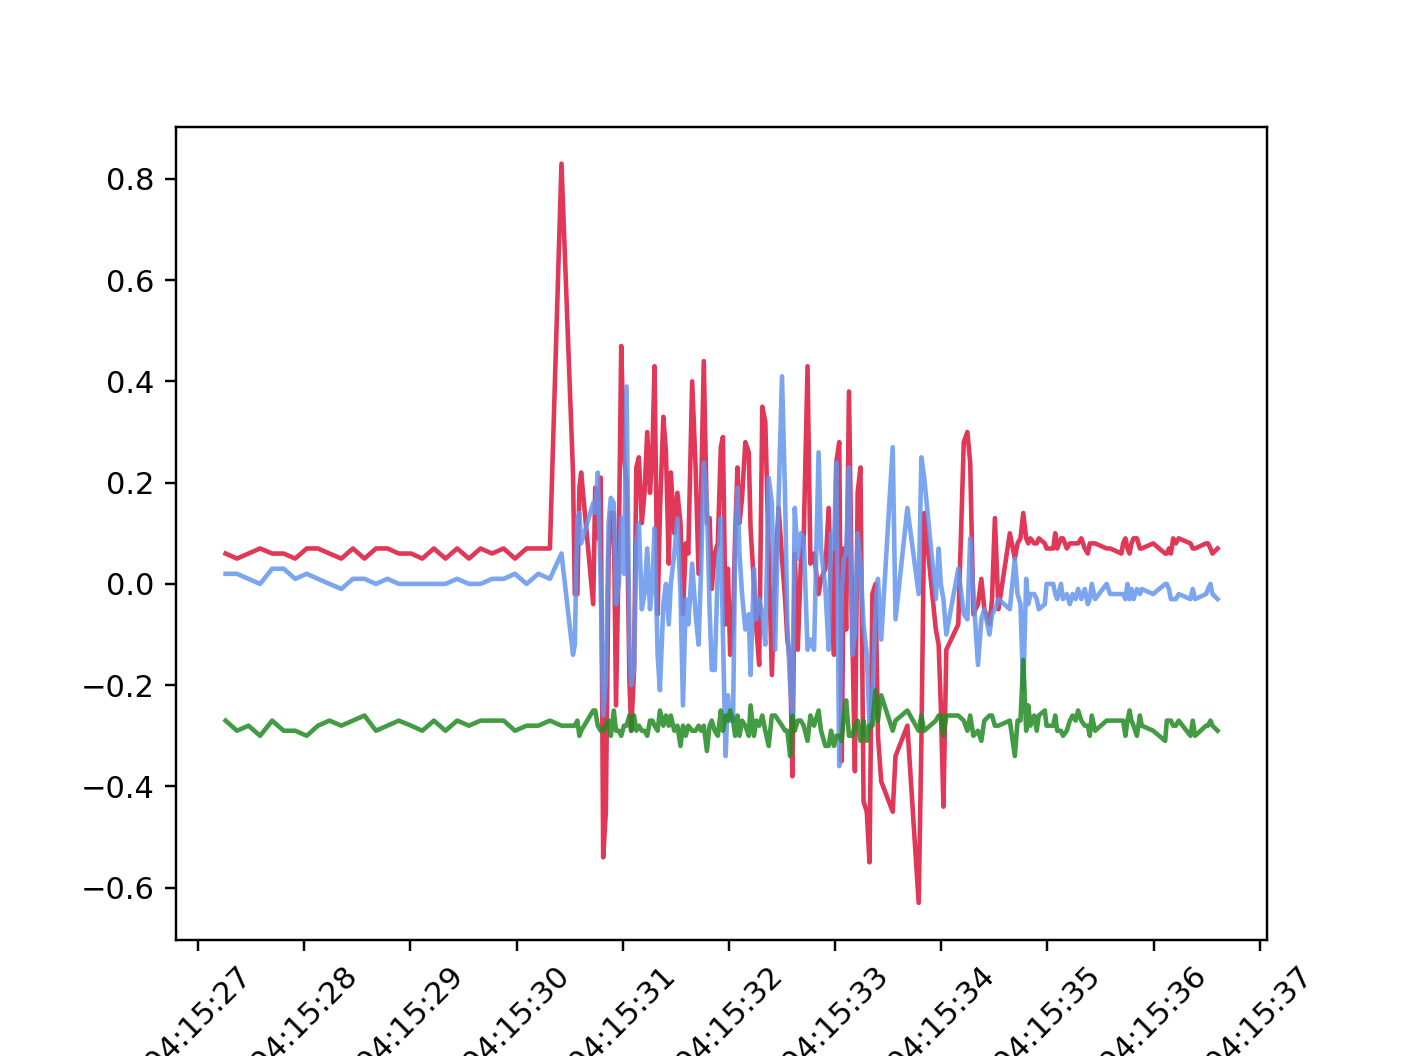

In [186]:
fig, ax = plt.subplots()
ax.plot(df["time"], df["x"], label="x axis", color="crimson", alpha=.85)
ax.plot(df["time"], df["y"], label="x axis", color="cornflowerblue", alpha=.85)
ax.plot(df["time"], df["z"], label="x axis", color="forestgreen", alpha=.85)
plt.xticks(rotation=45)
plt.show()

# Try Smoothing

In [187]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


<IPython.core.display.Javascript object>


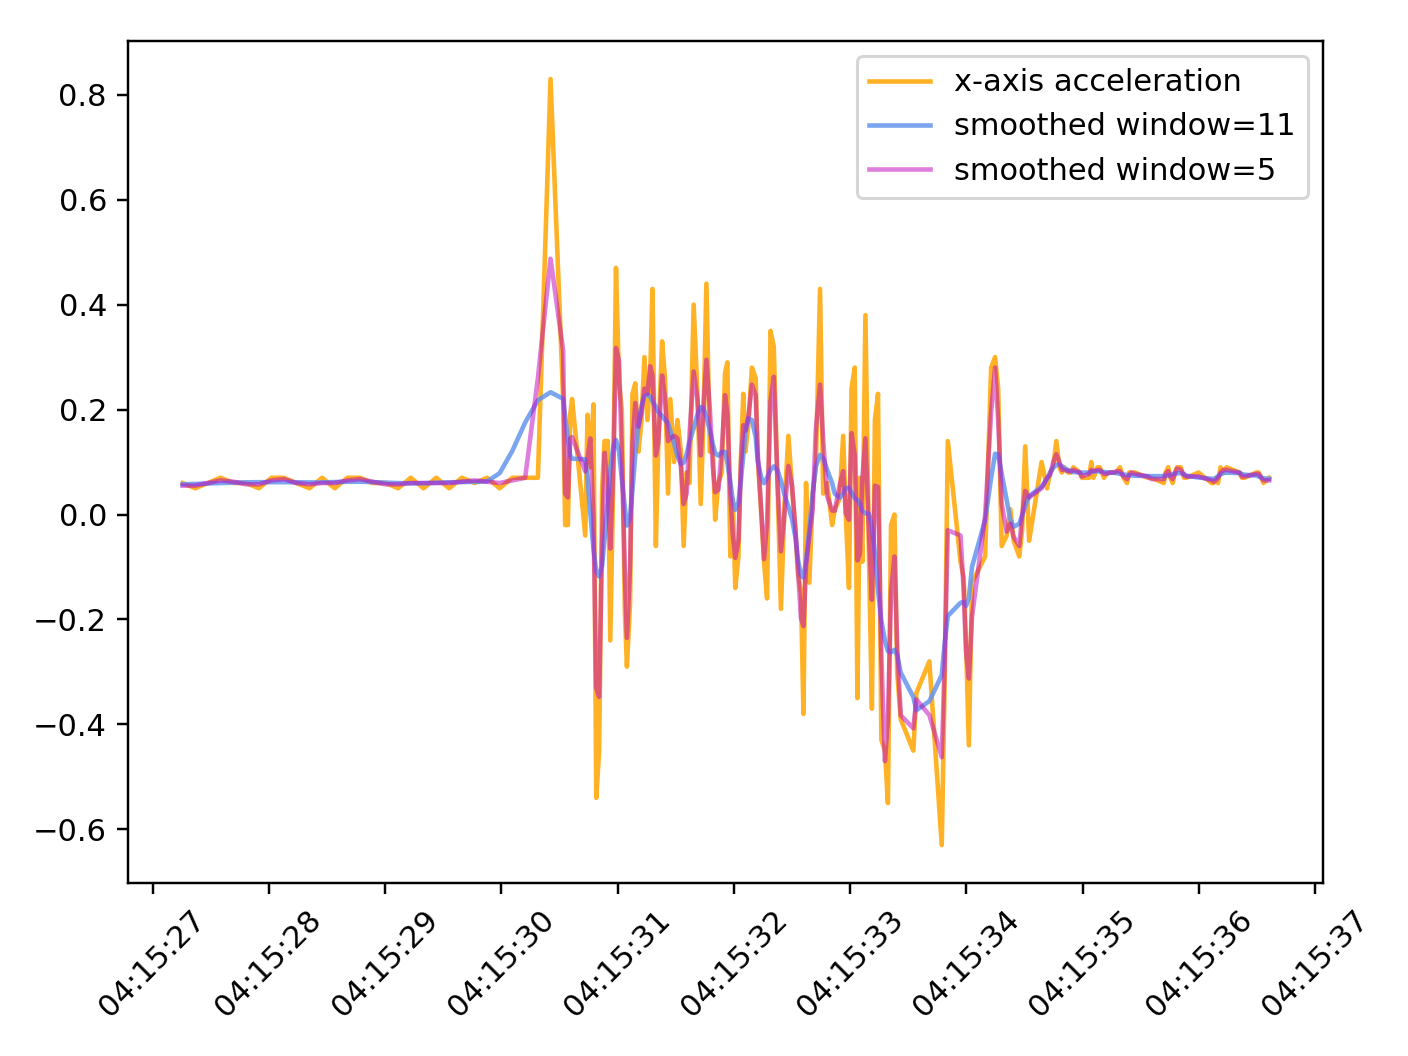

In [188]:
fig, ax = plt.subplots()
ax.plot(df["time"], df["x"], label="x-axis acceleration", color="orange", alpha=.85)
ax.plot(df["time"], smooth(df["x"])[5:-5], label="smoothed window=11", color="cornflowerblue", alpha=.85)
ax.plot(df["time"], smooth(df["x"], 5)[2:-2], label="smoothed window=5", color="m", alpha=.5)
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# Try to Integrate

In [195]:
from scipy.integrate import trapz, cumtrapz, simps

In [190]:
trapz(df["microseconds"].values, df["x"].values)

15579801473367.078

In [208]:
velocity = cumtrapz(df["x"].values, df["microseconds"].values)
velocity[:5]

array([ 5881.7  , 11873.345, 18940.535, 26334.805, 32839.345])

<IPython.core.display.Javascript object>


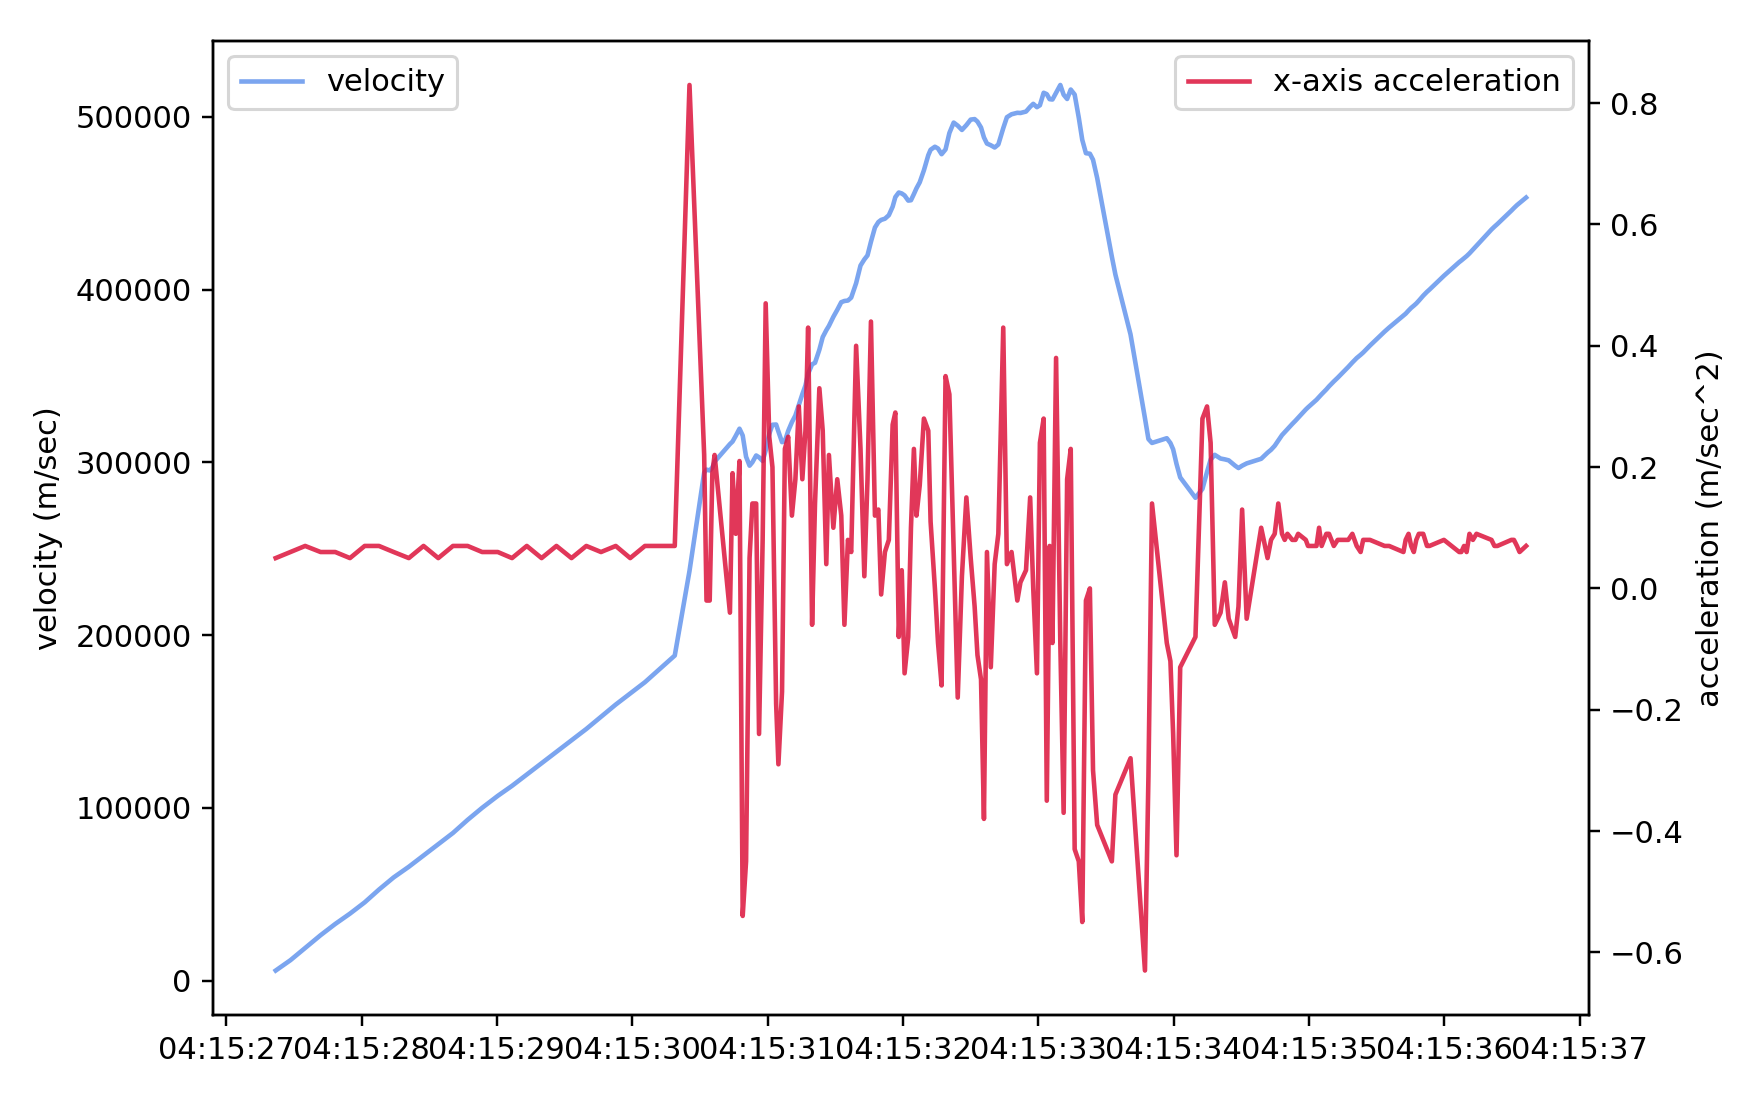

In [209]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(df["time"][1:], velocity, label="velocity", color="cornflowerblue", alpha=.85)

ax2 = ax1.twinx()
ax2.plot(df["time"][1:], df["x"][1:], label="x-axis acceleration", color="crimson", alpha=.85)

ax1.set_ylabel("velocity (m/sec)")
ax2.set_ylabel("acceleration (m/sec^2)")

ax1.legend(loc=2)
ax2.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [193]:
displacement = cumtrapz(velocity, df["microseconds"][1:].values)
displacement[:5]

array([9.67108424e+08, 2.64224338e+09, 5.21745945e+09, 8.42496466e+09,
       1.23199988e+10])

<IPython.core.display.Javascript object>


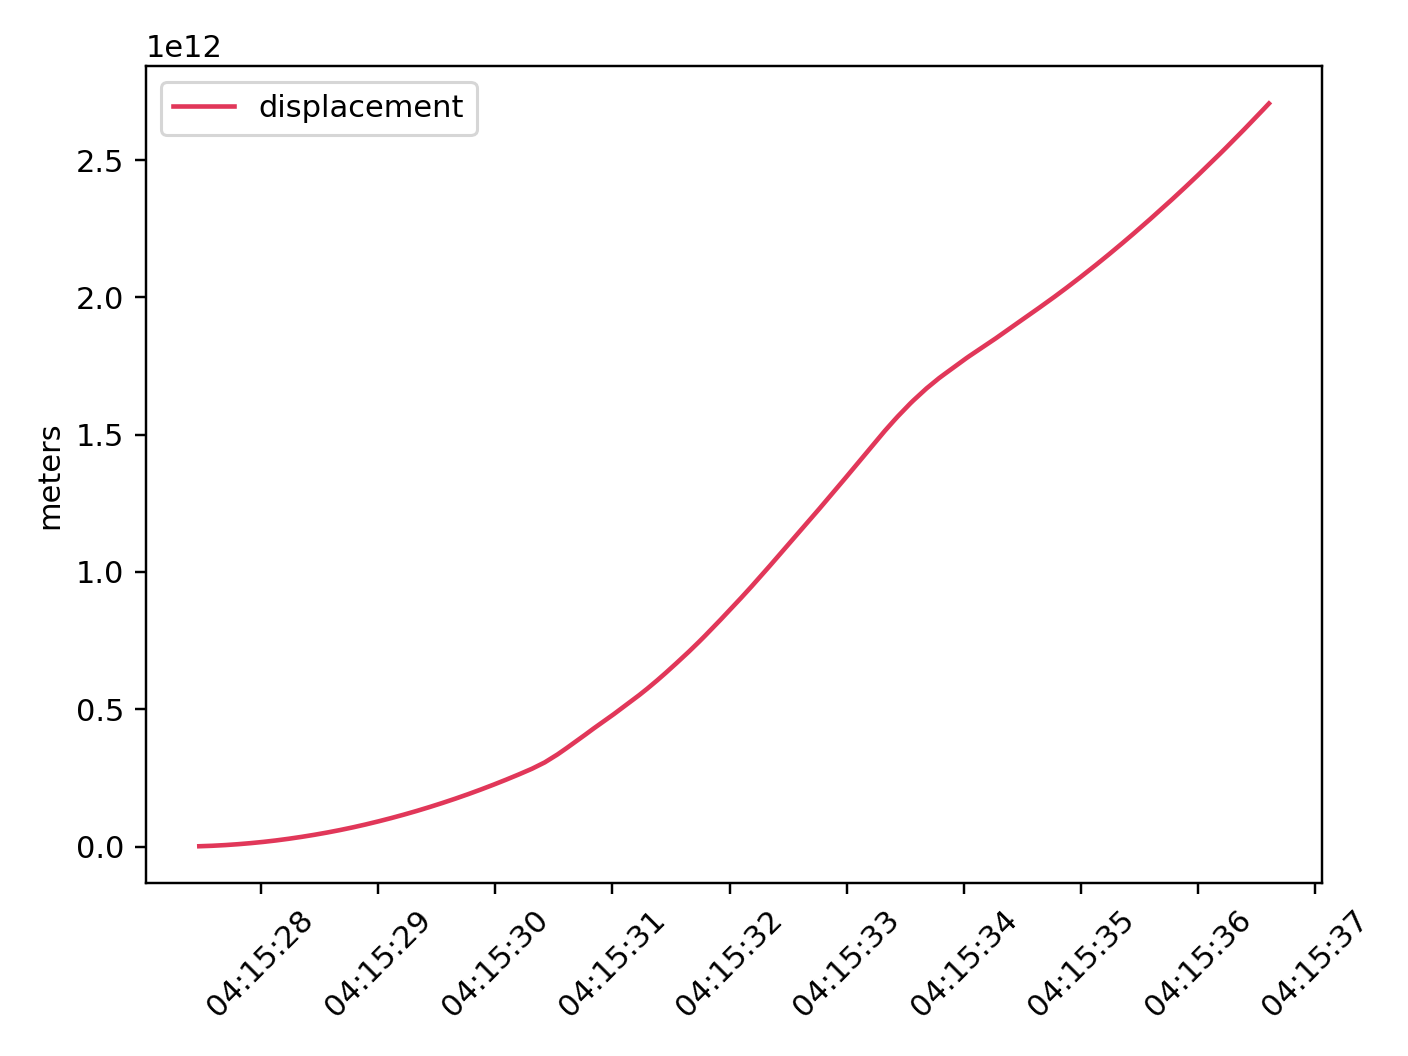

In [202]:
fig, ax = plt.subplots()
ax.plot(df["time"][2:], displacement, label="displacement", color="crimson", alpha=.85)
ax.legend()
ax.set_ylabel("meters")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()